In [143]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 12


In [144]:
def make_slice_volume(l_segs, r_segs, l_D=[], r_D=[]):
    mappings = tb.open_file('/projects/francisco/data/caffe/standardized/data_mappings.h5', 'r')
    l_baseline_mask = mappings.get_node('/l_datamask')[:]
    l_volmask = mappings.get_node('/l_volmask')[:]
    r_baseline_mask = mappings.get_node('/r_datamask')[:]
    r_volmask = mappings.get_node('/r_volmask')[:]
    mappings.close()
    
    l_vols = []
    for HC_input in l_segs:
        flatvol = np.zeros(np.prod(l_volmask.shape))
        flatvol[l_baseline_mask] = HC_input
        l_vols.append(flatvol.reshape(-1, l_volmask.shape[2]).T)

    r_vols = []
    for HC_input in r_segs:
        flatvol = np.zeros(np.prod(r_volmask.shape))
        flatvol[r_baseline_mask] = HC_input
        r_vols.append(flatvol.reshape(-1, r_volmask.shape[2]).T)

    r_vols = np.array(r_vols)
    l_vols = np.array(l_vols)
    
    r_M, r_D = slicify(r_vols, r_D)
    l_M, l_D = slicify(l_vols, l_D)
    return l_M, r_M, l_D, r_D

def slicify(vol, disjoints=[]):
    xmax = vol.shape[2] - 1
    
    if disjoints == []:
        x = 0
        while x < xmax and np.sum(vol[:,:,x]) == 0:
            x += 1
            if np.sum(vol[:,:,x] > 0):
                cur_l = x
                while x < xmax and np.sum(vol[:,:,x]) > 0:
                    x += 1
                if not x == xmax:
                    disjoints.append((cur_l, x))

    M = np.zeros(shape=(vol.shape[0], len(disjoints)))
    
    for u in range(vol.shape[0]):
        for j in range(len(disjoints)):
            l, r = disjoints[j]
            M[u,j] = np.sum(vol[u,:,l:r])

    
    return M, disjoints


In [145]:
import tables as tb
from sklearn.preprocessing import Normalizer, scale

# Set up the experimental matrices:
targets = ['ADAS11_bl', 'ADAS13_bl', 'MMSE_bl']
targets_regex = '|'.join(['^{}$'.format(t) for t in targets])
#modalities = ['CT', 'L_HC', 'R_HC']
modalities = ['CT']
l_segment_regex = '^L_HC_'
r_segment_regex = '^R_HC_'
modalities_regex = '|'.join(['^{}_'.format(m) for m in modalities])

matrices = []
l_D = []
r_D = []
for split in ['train', 'valid', 'test']:
    frame = pd.read_pickle('/projects/francisco/data/ADNI/cli_ct_seg_fused_{}.pkl'.format(split))
    X_cur = frame.filter(regex=modalities_regex).as_matrix()
    y_cur = frame.filter(regex=targets_regex).as_matrix()
    
    # Reconstruct segmentation maps into 3d volumes and reduce to normalized slice volume measurements:
    l_segs = frame.filter(regex=l_segment_regex).as_matrix()
    r_segs = frame.filter(regex=r_segment_regex).as_matrix()
    l_M, r_M, l_D, r_D = make_slice_volume(l_segs, r_segs, l_D, r_D)
    print 'Seg Vol Shapes: {} {}'.format(l_M.shape, r_M.shape)
    
    X_cur = np.concatenate([X_cur, l_M, r_M], axis=1)
    # Replaces nans with mean: revisit this later
    y_cur[np.isnan(y_cur)] = np.nanmean(y_cur)
    matrices.append((X_cur,y_cur))

var_names = frame.filter(regex=modalities_regex).columns
var_names = list(var_names)
var_names.extend(['L_HC_V{}'.format(i) for i in range(l_M.shape[1])])
var_names.extend(['R_HC_V{}'.format(i) for i in range(r_M.shape[1])])
var_names = np.array(var_names)

X, y = matrices[0][0], matrices[0][1]
X_v, y_v = matrices[1][0], matrices[1][1]
X_t, y_t = matrices[2][0], matrices[2][1]

# norm = Normalizer()
# X = norm.fit_transform(X)
# X_v = norm.transform(X_v)
# X_t = norm.transform(X_t)
# X = scale(X, with_std=False)
# X_v = scale(X_v, with_std=False)
# X_t = scale(X_t, with_std=False)

print 'Training, Validation, and Testing X, y shapes:'
print X.shape, y.shape
print X_v.shape, y_v.shape
print X_t.shape, y_t.shape

nans = np.sum(np.isnan(y))
print 'Number of delicious nans in y is {}'.format(nans) + ' :(' if nans == 0 else ''

Seg Vol Shapes: (490, 33) (490, 34)
Seg Vol Shapes: (98, 33) (98, 34)
Seg Vol Shapes: (110, 33) (110, 34)
Training, Validation, and Testing X, y shapes:
(490, 141) (490, 3)
(98, 141) (98, 3)
(110, 141) (110, 3)
Number of delicious nans in y is 0 :(


In [146]:
print np.std(X,axis=0)
print np.mean(X,axis=0)


[  0.23859899   0.30365357   0.24589041   0.29871112   0.26291972
   0.23280322   0.27249513   0.23492558   0.19983846   0.20686221
   0.26376937   0.29914064   0.31648332   0.22977159   0.20721415
   0.18908846   0.24325035   0.22394164   0.21628576   0.27025311
   0.2082626    0.27841834   0.23879721   0.22896088   0.24144429
   0.21666296   0.17206565   0.20152495   0.22741642   0.21387995
   0.21866396   0.23112245   0.35572518   0.30746627   0.27586899
   0.19644957   0.28791181   0.22539268   0.30444791   0.24327379
   0.26119504   0.25771214   0.23063412   0.27114013   0.23215903
   0.20782489   0.2224284    0.31317855   0.32134407   0.32130524
   0.23325713   0.20784972   0.18206914   0.23329587   0.2227503
   0.21307805   0.24656906   0.19974052   0.25172417   0.2278283
   0.23408425   0.23670655   0.20262501   0.17014467   0.18063806
   0.25086723   0.22180028   0.21363603   0.21686988   0.32713024
   0.28252596   0.22221341   0.19909221   0.28483968   0.13538782
   1.4058913

In [147]:
def adjusted_r2(y_hat, y, p, n):
    """
    And I quote:
    "adjusted R2 is a comparative measure of suitability of alternative nested sets of explanators"
    """
    r2 = metrics.r2_score(y_hat, y)
    adj_r2 = r2 - (1 - r2) * (p / n - p - 1)
    return r2
    

    

# vol = r_vols[0]
# s = 0
# for x1, x2 in disjoints:
#     s += 1
#     plt.subplot(1, len(disjoints), s)
#     chunk = vol[:,x1:x2]
#     plt.imshow(chunk, aspect='auto', cmap=plt.cm.Blues, interpolation='none')
#     plt.axis('off')

# plt.figure()
# plt.imshow(vol, cmap=plt.cm.Blues, aspect='auto', interpolation='none')
# plt.axis('off')


In [148]:
from sklearn.linear_model import SGDRegressor, BayesianRidge, RidgeCV
from sklearn.decomposition import RandomizedPCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn import metrics

num_targets = len(targets)
num_models = 3 # Includes dummy model
k_nums = range(1, X.shape[1], 5)
k_nums.append(X.shape[1])
k_classifiers = []
k_selectors = []
stats = np.zeros(shape=(len(k_nums), 3, num_models, num_targets))
for i, k in enumerate(k_nums):
    cur_triple = []
    cur_sel_triple = []
    for t in range(0,len(targets)):
        
        dummy_regressor = DummyRegressor(strategy='mean')
        dsel = SelectKBest(f_regression, k=k)
        
        classifier = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None, normalize=True)
        sel = SelectKBest(f_regression, k=k)
        
        bayes_classifier = BayesianRidge(compute_score=True, normalize=True)
        bsel = SelectKBest(f_regression, k=k)
        
        classifiers = [classifier, bayes_classifier, dummy_regressor]
        
        # Feature Selection
        sel.fit(X, y[:,t])
        bsel.fit(X, y[:,t])
        dsel.fit(X, y[:, t])
        
        cur_sel_triple.append((sel, bsel, dsel))
        support = sel.get_support(indices=True)
        bsupport = bsel.get_support(indices=True)
        dsupport = dsel.get_support(indices=True)
        #support = range(k)
        
        # Feature transformation for train set
        X_hat = sel.transform(X)
        X_hatb = bsel.transform(X)
        X_hatd = dsel.transform(X)
        
        # Feature transformation for validation set
        X_hat_v = sel.transform(X_v)
        X_hat_vb = bsel.transform(X_v)
        X_hat_vd = dsel.transform(X_v)

        # Train classifiers on transformed training X
        classifier.fit(X_hat, y[:,t])
        bayes_classifier.fit(X_hatb, y[:,t])
        dummy_regressor.fit(X_hatd, y[:,t])
        
        # Save classifiers for visualizing on later
        cur_triple.append((classifier, bayes_classifier, dummy_regressor))

        # Predict on validation data and log stats
        y_hat_v = classifier.predict(X_hat_v)
        y_hat_vb = bayes_classifier.predict(X_hat_vb)
        y_hat_vd = dummy_regressor.predict(X_hat_vd)
        stats[i,0,0,t] = k
        stats[i,1,0,t] =  metrics.mean_squared_error(y_hat_v, y_v[:,t])
        stats[i,2,0,t] =  adjusted_r2(y_hat_v, y_v[:,t], X_hat.shape[1], X_hat.shape[0])
        stats[i,1,1,t] =  metrics.mean_squared_error(y_hat_vb, y_v[:,t])
        stats[i,2,1,t] =  adjusted_r2(y_hat_vb, y_v[:,t], X_hat_vb.shape[1], X_hat_vb.shape[0])
        stats[i,1,2,t] =  metrics.mean_squared_error(y_hat_vd, y_v[:,t])
        stats[i,2,2,t] =  adjusted_r2(y_hat_vd, y_v[:,t], X_hat_vd.shape[1], X_hat_vd.shape[0])
    k_selectors.append(cur_sel_triple)
    k_classifiers.append(cur_triple)



In [149]:
T = 1 # Current target index

k = stats[:,0,0]
rss = stats[:,1,0]
brss = stats[:,1,1]
drss = stats[:,1,2]
vs = stats[:,2,0]
bvs = stats[:,2,1]
dvs = stats[:,2,2]
stats_table = np.zeros(shape=(len(k_nums), 7, 3))
for i in range(3):
    stats_table[:,:,i] = np.vstack([k[:,i], rss[:,i], brss[:,i], drss[:,i], vs[:,i], bvs[:,i], dvs[:,i]]).T

print 

In [150]:
from tabulate import tabulate
for i in range(3):
    print
    print 'Y: {}'.format(targets[i])
    print tabulate(stats_table[:,:,i], ['K', 'MSE', 'b_MSE', 'd_MSE', 'R2', 'b_R2', 'd_R2'])



Y: ADAS11_bl
  K      MSE    b_MSE    d_MSE         R2      b_R2    d_R2
---  -------  -------  -------  ---------  --------  ------
  1  39.9285  40.4685  37.7299  -10.1894   -8.56689       0
  6  35.6944  35.6944  37.7299   -5.09723  -5.09651       0
 11  35.6373  35.6766  37.7299   -6.71029  -5.26395       0
 16  35.1249  35.1577  37.7299   -4.9392   -5.13293       0
 21  36.2162  36.0285  37.7299   -5.20148  -5.49734       0
 26  35.016   34.9454  37.7299   -4.49529  -5.00245       0
 31  34.3337  34.4796  37.7299   -4.42283  -5.04709       0
 36  34.7276  34.763   37.7299   -4.42076  -5.14109       0
 41  35.1819  34.9538  37.7299   -3.74028  -4.58659       0
 46  34.6938  34.5972  37.7299   -3.56144  -4.51643       0
 51  35.2019  34.8128  37.7299   -3.33879  -4.35275       0
 56  34.7837  34.7432  37.7299   -5.70564  -4.16664       0
 61  34.3679  34.0892  37.7299   -5.62079  -4.11524       0
 66  33.9738  33.6207  37.7299   -5.54731  -4.02458       0
 71  34.4863  34.6157  37.

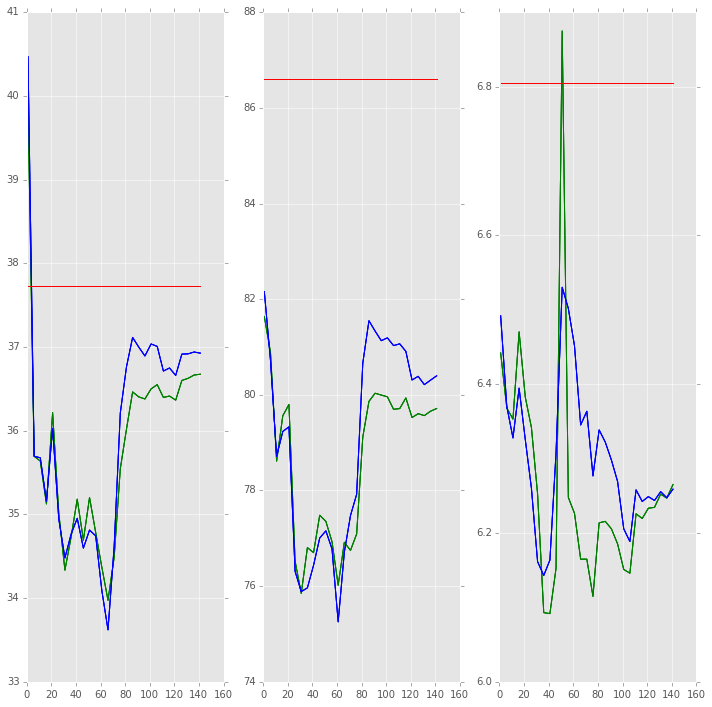

In [151]:
plt.figure(1)
plt.cla()
plt.xscale('log')
plt.yscale('log')
plt.xticks(k_nums, k_nums)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(k, rss[:,i], 'g', label='logreg')
    plt.plot(k, brss[:, i], 'b', label='bayesian reg')
    plt.plot(k, drss[:, i], 'r', label='dummy reg')


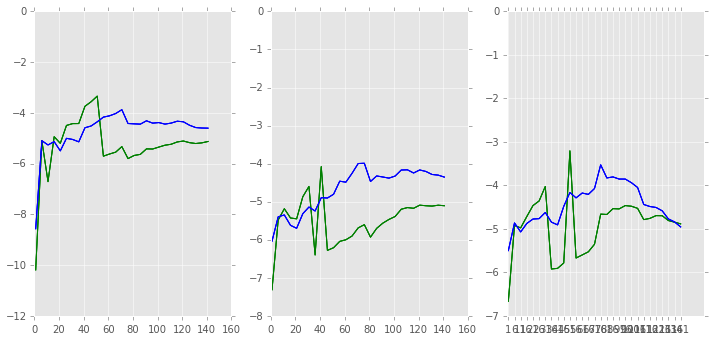

In [152]:
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(k, vs[:,i], 'g', label='logreg')
    plt.plot(k, bvs[:, i], 'b', label='bayesian reg')
    plt.plot(k, dvs[:, i], 'r', label='dummy reg')
    
plt.xticks(k_nums, k_nums)
plt.show()

In [153]:
print k_nums

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141]


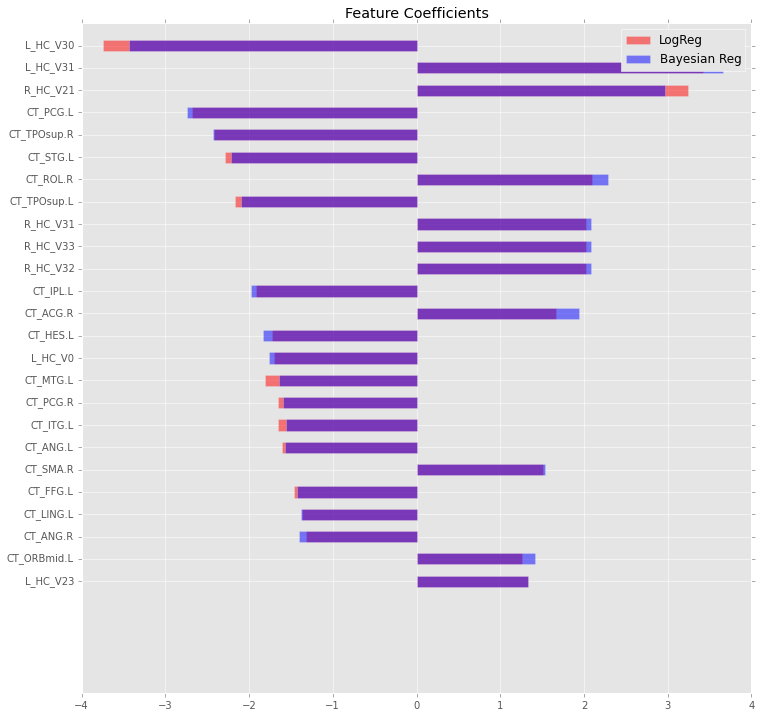

In [154]:
# Pick a classifier, plot the feature weights
K = 141 # K components to visualize
T = 0 # Target clinical scale to visualize
k_ind = k_nums.index(K)
classifiers_pair = k_classifiers[k_ind][T]
c = classifiers_pair[0]     
b = classifiers_pair[1]
log_coefs = scale(c.coef_)
bayes_coefs = scale(b.coef_)
feats = zip(var_names[support], log_coefs, bayes_coefs)
feats.sort(reverse=False, key=lambda x: abs(x[1]) + abs(x[2]))
feats = feats[-25:]
# Plot the feature importances of the classifier
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))
plt.barh(y_pos, width=zip(*feats)[1], height=0.5, color='r', align="center", alpha=0.5, label='LogReg')
plt.barh(y_pos, width=zip(*feats)[2], height=0.5, color='b', align="center", alpha=0.5, label='Bayesian Reg')
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()

In [155]:
sel = k_selectors[k_ind]
classers = k_classifiers[k_ind]
# Show test predictions
preds = np.zeros(shape=(y_t.shape[0],9))
header = []
summary = []
summary_header = []
for i in range(3):
    col = i * 3
    X_t_r = sel[i][0].transform(X_t)
    X_t_rb = sel[i][1].transform(X_t)
    y_t_hat = classers[i][0].predict(X_t_r)
    y_t_hatb = classers[i][1].predict(X_t_rb)
    preds[:,col] = y_t[:,i]
    preds[:,col + 1] = y_t_hat
    preds[:,col + 2] = y_t_hatb
    for t in targets:
        header.append(t)
        header.append('l y_hat')
        header.append('b y_hat')
    summary.extend([
            metrics.mean_squared_error(y_t_hat, y_t[:,i]),
            metrics.mean_squared_error(y_t_hatb, y_t[:,i]),
            metrics.r2_score(y_t_hat, y_t[:,i]),
            metrics.r2_score(y_t_hatb, y_t[:,i]),
        ])

    summary_header.extend(['l MMSE', 'b MMSE', 'l R2', 'b R2'])

print tabulate([summary], summary_header)
print
print tabulate(preds, header)




  l MMSE    b MMSE     l R2      b R2    l MMSE    b MMSE      l R2      b R2    l MMSE    b MMSE      l R2      b R2
--------  --------  -------  --------  --------  --------  --------  --------  --------  --------  --------  --------
 34.6996   34.7224  -3.4565  -3.09787   67.1169   67.0637  -2.79985  -2.38348   4.58002   4.58328  -2.20041  -2.24416

  ADAS11_bl    l y_hat    b y_hat    ADAS13_bl    l y_hat    b y_hat    MMSE_bl    l y_hat    b y_hat
-----------  ---------  ---------  -----------  ---------  ---------  ---------  ---------  ---------
      16       9.98175    9.98225        26      15.5692    15.4684          26    27.8752    27.8675
      21.67   15.1251    15.0956         33.67   25.0405    25.2238          23    24.4812    24.5001
       5       9.2655     9.00501         9      14.5233    14.0463          28    27.7544    27.7408
       9.67   13.3891    13.6557         15.67   20.7083    21.0898          26    26.2516    26.2598
       8.67   10.1405    10.0884 